In [36]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
df = pd.read_csv('/content/cafethai_prices.csv', parse_dates=['date'], date_format='%d/%m/%Y')
display(df.head())


,date,time,cash_type,coffee_name,money
0,2023-03-01,08:04:19,card,Latte,75
1,2023-03-01,08:08:54,cash,Americano with Milk,70
2,2023-03-01,08:09:03,card,Cappuccino,75
3,2023-03-01,08:10:26,cash,Cappuccino,75
4,2023-03-01,08:15:37,cash,Cappuccino,75


In [38]:
daily = (
    df
    .groupby(['coffee_name','date'])
    .size()
    .reset_index(name='count')
)

In [39]:
daily = daily.sort_values(['coffee_name','date']).reset_index(drop=True)

In [40]:
for lag in range(1, 61):
    daily[f'lag_{lag}'] = daily.groupby('coffee_name')['count'].shift(lag)

In [41]:
cols_lag = [f'lag_{i}' for i in range(1,61)]
final_data = daily.dropna(subset=cols_lag + ['count']).reset_index(drop=True)

In [42]:
split_date = pd.to_datetime('2025-03-01')
test_end   = split_date + pd.Timedelta(days=60)

In [43]:
train_data = final_data[ final_data['date'] < split_date ]
test_data  = final_data[
    (final_data['date'] >= split_date) &
    (final_data['date'] <  test_end)
].reset_index(drop=True)

FEATURES = cols_lag
TARGET   = 'count'

X_train = train_data[FEATURES].values
y_train = train_data[TARGET].values
X_test  = test_data[FEATURES].values
y_test  = test_data[TARGET].values

In [44]:
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

In [45]:
from sklearn.ensemble import RandomForestRegressor

In [46]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [47]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    random_state=42,
    eval_metric='rmse',
    early_stopping_rounds=20
)

xgb_model.fit(
    X_tr, y_tr,
    eval_set=[(X_val, y_val)],
    verbose=False
)

test_data['pred_xgb'] = xgb_model.predict(X_test).round().astype(int)

In [48]:
test_data['pred_rf']  = rf.predict(X_test).round().astype(int)
test_data['pred_xgb'] = xgb_model.predict(X_test).round().astype(int)

In [49]:
mae_rf  = mean_absolute_error(y_test, test_data['pred_rf'])
mae_xgb = mean_absolute_error(y_test, test_data['pred_xgb'])
print(f"MAE รวม Random Forest: {mae_rf:.2f}")
print(f"MAE รวม XGBoost     : {mae_xgb:.2f}")

MAE รวม Random Forest: 3.73
MAE รวม XGBoost     : 3.77


In [50]:
mae_per_menu = (
    test_data
    .groupby('coffee_name')
    .apply(lambda d: mean_absolute_error(d['count'], d['pred_xgb']))
    .reset_index(name='XGB_MAE')
)
print("\nMAE XGBoost แยกเมนู:")
print(mae_per_menu.to_string(index=False))


MAE XGBoost แยกเมนู:
        coffee_name  XGB_MAE
          Americano 4.900000
Americano with Milk 5.900000
         Cappuccino 4.166667
              Cocoa 2.559322
            Cortado 2.783333
           Espresso 1.581818
      Hot Chocolate 2.633333
              Latte 5.466667


/tmp/ipython-input-3613017290.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d: mean_absolute_error(d['count'], d['pred_xgb']))


In [51]:
summary = (
    test_data
    .groupby('coffee_name')[['count','pred_xgb']]
    .sum()
    .rename(columns={'count':'actual_sum','pred_xgb':'xgb_sum'})
    .reset_index()
)
print("\nยอดขายรวมจริง vs XGBoost พยากรณ์ (60 วัน):")
print(summary.to_string(index=False))


ยอดขายรวมจริง vs XGBoost พยากรณ์ (60 วัน):
        coffee_name  actual_sum  xgb_sum
          Americano         844      860
Americano with Milk        1230     1176
         Cappuccino         743      779
              Cocoa         383      402
            Cortado         406      425
           Espresso         185      210
      Hot Chocolate         428      432
              Latte        1125     1181


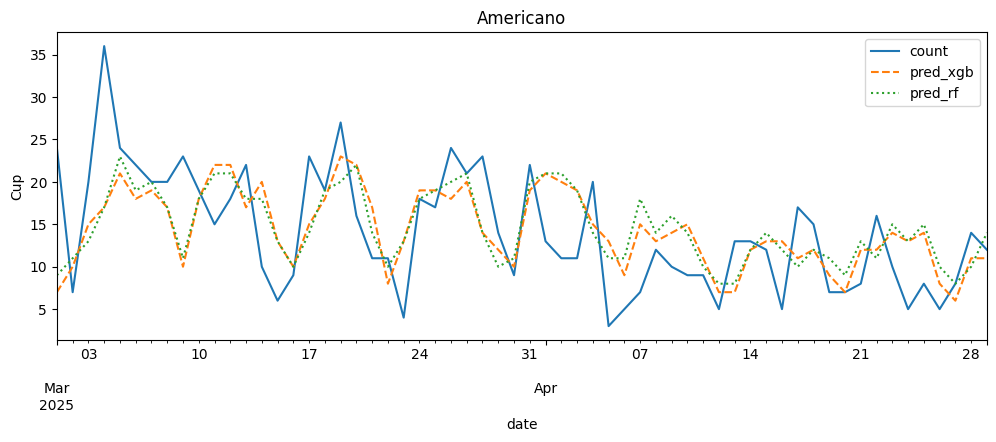

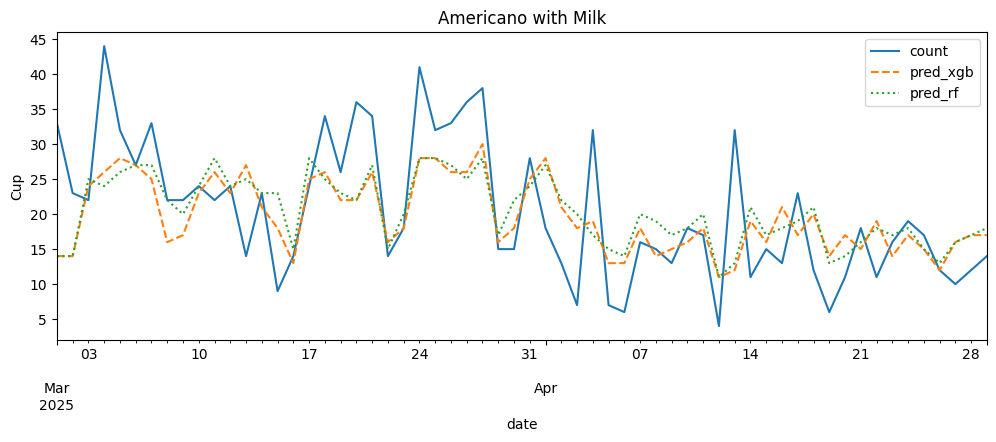

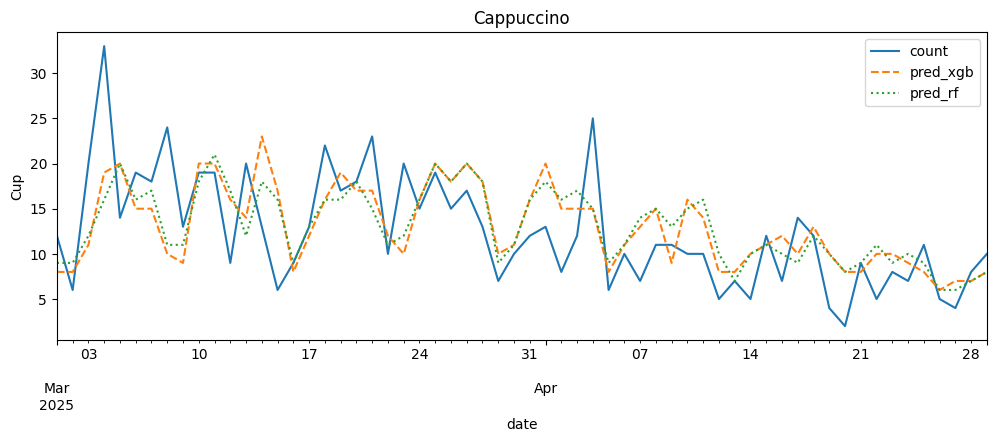

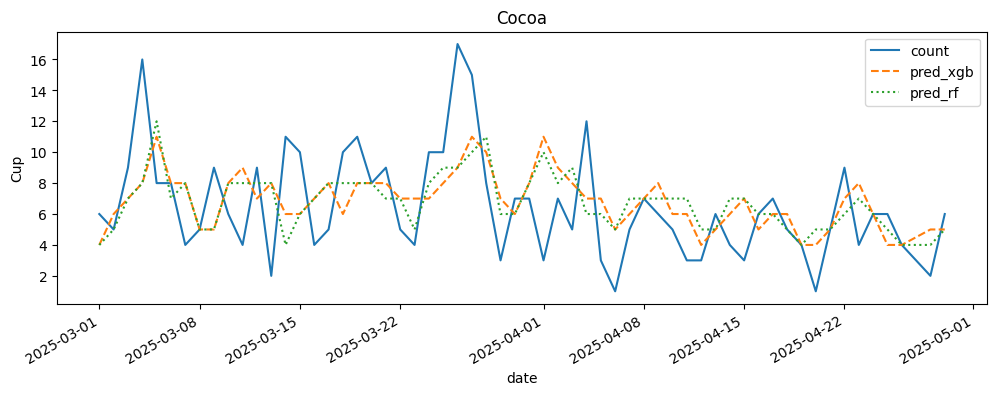

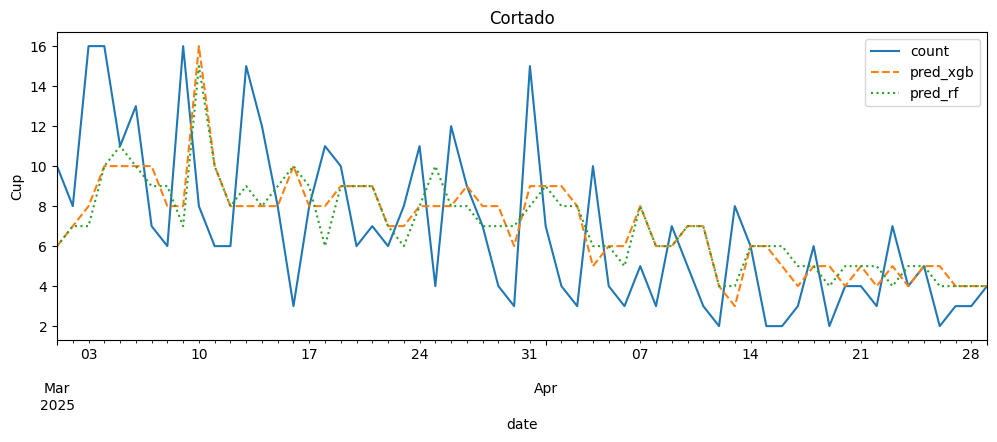

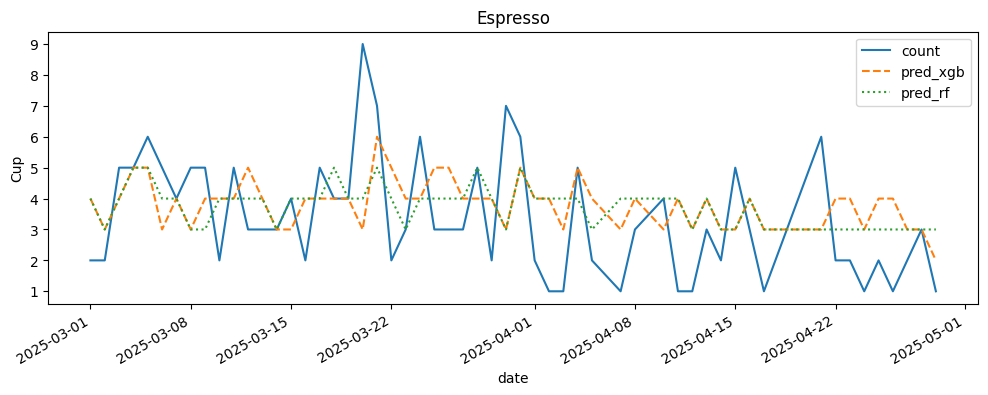

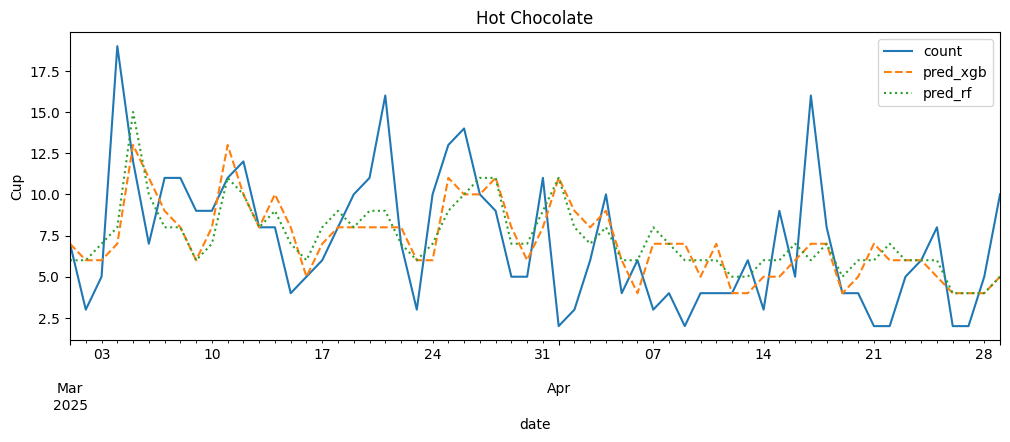

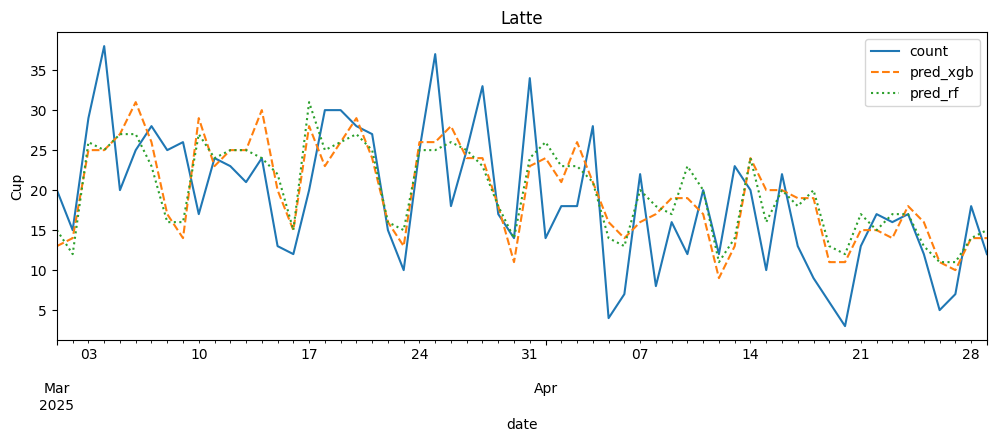

In [55]:
import matplotlib.pyplot as plt

test_data['date'] = pd.to_datetime(test_data['date'])

for coffee, dfp in test_data.groupby('coffee_name'):
    dfp = dfp.sort_values('date').set_index('date')

    ax = dfp[['count','pred_xgb','pred_rf']].plot(
        figsize=(12,4),
        title=coffee,
        style=['-','--',':']
    )
    ax.set_ylabel('Cup')
    plt.show()

In [53]:
pip install prophet

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx6i3ck7b/r6vgqxvx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx6i3ck7b/kgfagyur.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86239', 'data', 'file=/tmp/tmpx6i3ck7b/r6vgqxvx.json', 'init=/tmp/tmpx6i3ck7b/kgfagyur.json', 'output', 'file=/tmp/tmpx6i3ck7b/prophet_modelr31178xm/prophet_model-20250921162641.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:26:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:26:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.12/dist-packages/prophet/plot.py:95: UserWarning: Glyph 3649 (\N{THAI CHARACTER SARA AE}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
/usr/local/lib/python3.12/dist-packages/prophet/plot.py:95: UserWarning: G

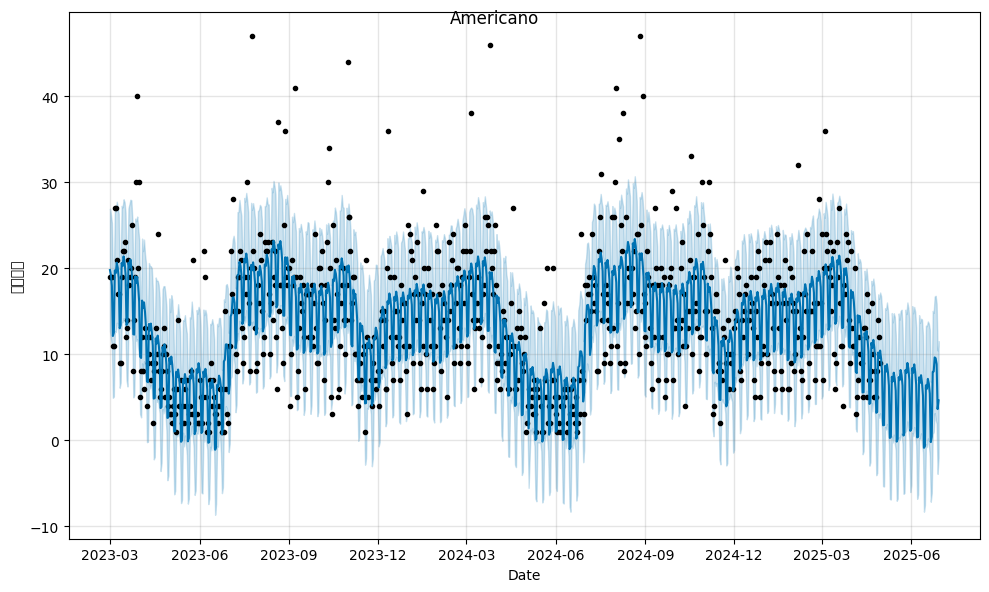

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx6i3ck7b/npp13da9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx6i3ck7b/882rnx9d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=696', 'data', 'file=/tmp/tmpx6i3ck7b/npp13da9.json', 'init=/tmp/tmpx6i3ck7b/882rnx9d.json', 'output', 'file=/tmp/tmpx6i3ck7b/prophet_modela65qriff/prophet_model-20250921162642.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:26:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:26:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.12/dist-packages/prophet/plot.py:95: UserWarning: Glyph 3649 (\N{THAI CHARACTER SARA AE}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
/usr/local/lib/python3.12/dist-packages/prophet/plot.py:95: UserWarning: Gly

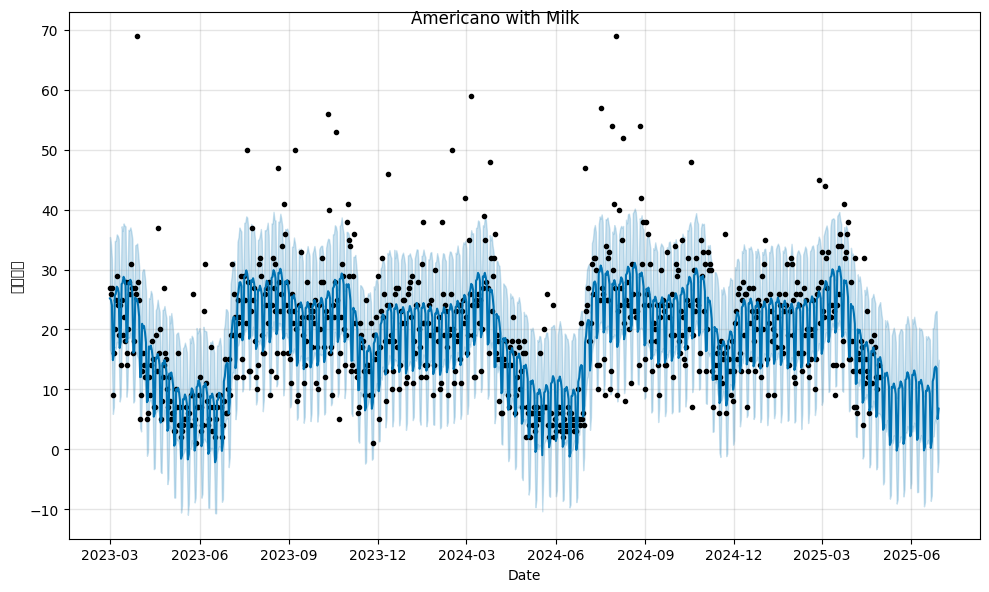

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx6i3ck7b/qf6s05ry.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx6i3ck7b/0z3_5383.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63452', 'data', 'file=/tmp/tmpx6i3ck7b/qf6s05ry.json', 'init=/tmp/tmpx6i3ck7b/0z3_5383.json', 'output', 'file=/tmp/tmpx6i3ck7b/prophet_modelnw65oeyw/prophet_model-20250921162643.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:26:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:26:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.12/dist-packages/prophet/plot.py:95: UserWarning: Glyph 3649 (\N{THAI CHARACTER SARA AE}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
/usr/local/lib/python3.12/dist-packages/prophet/plot.py:95: UserWarning: G

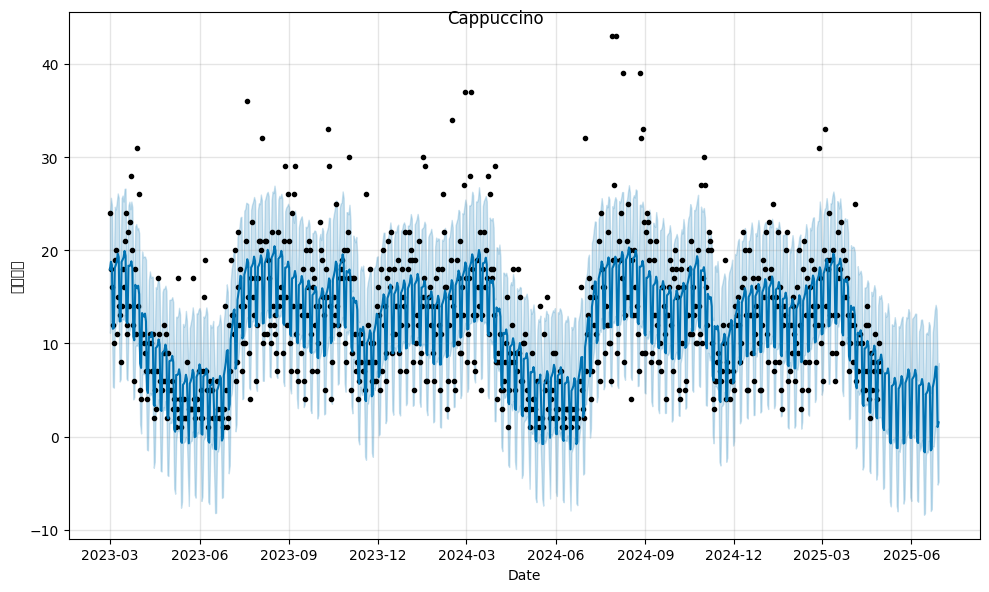

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx6i3ck7b/7pluzpvl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx6i3ck7b/q8mjs_nx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70240', 'data', 'file=/tmp/tmpx6i3ck7b/7pluzpvl.json', 'init=/tmp/tmpx6i3ck7b/q8mjs_nx.json', 'output', 'file=/tmp/tmpx6i3ck7b/prophet_modelfmx_6rc7/prophet_model-20250921162644.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:26:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:26:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.12/dist-packages/prophet/plot.py:95: UserWarning: Glyph 3649 (\N{THAI CHARACTER SARA AE}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
/usr/local/lib/python3.12/dist-packages/prophet/plot.py:95: UserWarning: G

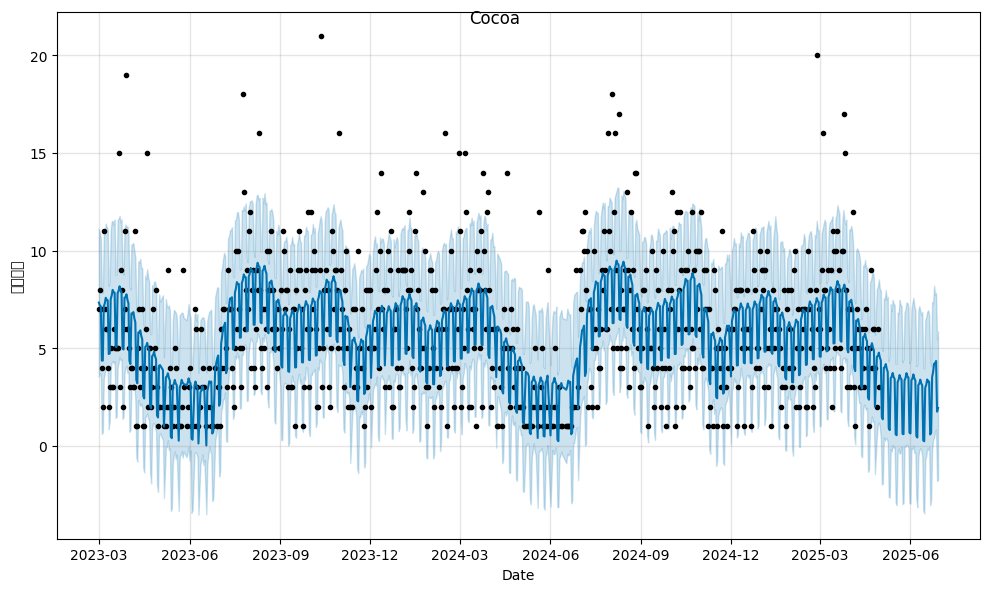

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx6i3ck7b/0647itqg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx6i3ck7b/mpkw5dtp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65490', 'data', 'file=/tmp/tmpx6i3ck7b/0647itqg.json', 'init=/tmp/tmpx6i3ck7b/mpkw5dtp.json', 'output', 'file=/tmp/tmpx6i3ck7b/prophet_modelh2ludf2c/prophet_model-20250921162644.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:26:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:26:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.12/dist-packages/prophet/plot.py:95: UserWarning: Glyph 3649 (\N{THAI CHARACTER SARA AE}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
/usr/local/lib/python3.12/dist-packages/prophet/plot.py:95: UserWarning: G

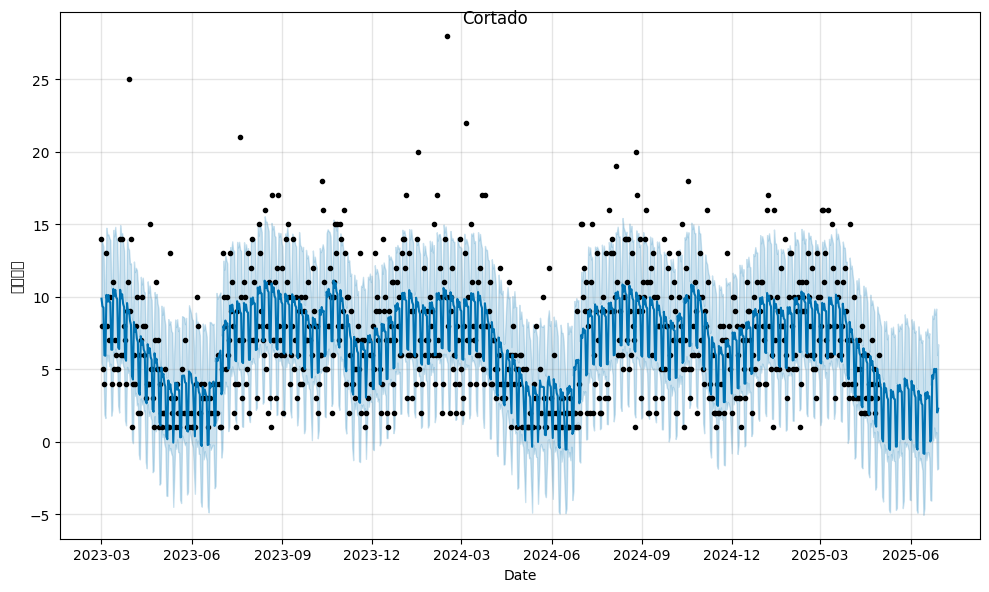

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx6i3ck7b/sj7xer32.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx6i3ck7b/nmo_a02k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69863', 'data', 'file=/tmp/tmpx6i3ck7b/sj7xer32.json', 'init=/tmp/tmpx6i3ck7b/nmo_a02k.json', 'output', 'file=/tmp/tmpx6i3ck7b/prophet_modelf8lhe3kg/prophet_model-20250921162646.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:26:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:26:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.12/dist-packages/prophet/plot.py:95: UserWarning: Glyph 3649 (\N{THAI CHARACTER SARA AE}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
/usr/local/lib/python3.12/dist-packages/prophet/plot.py:95: UserWarning: G

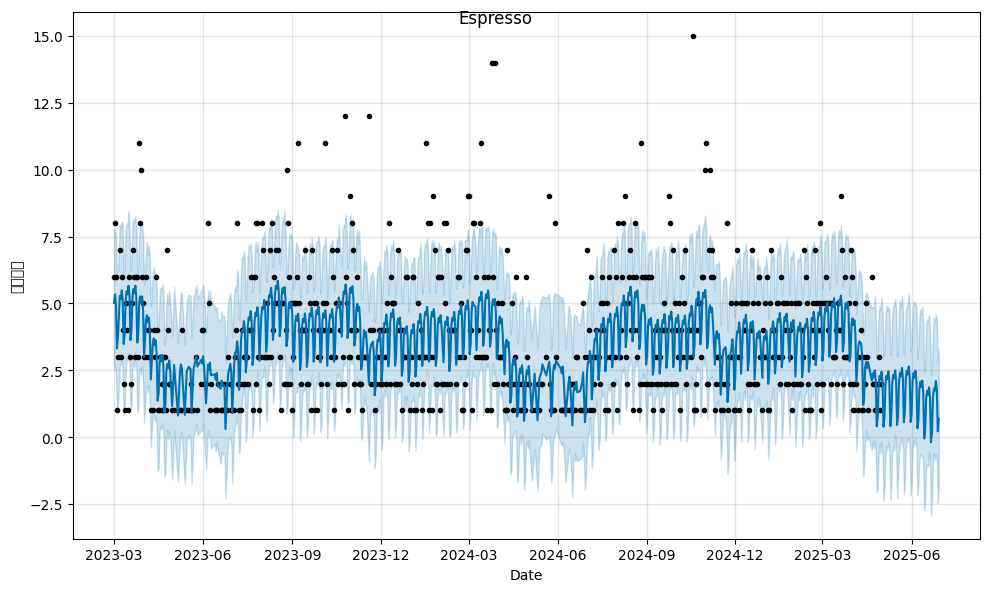

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx6i3ck7b/chxd1p34.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx6i3ck7b/xj902p9a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93438', 'data', 'file=/tmp/tmpx6i3ck7b/chxd1p34.json', 'init=/tmp/tmpx6i3ck7b/xj902p9a.json', 'output', 'file=/tmp/tmpx6i3ck7b/prophet_model3q6slvhd/prophet_model-20250921162647.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:26:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:26:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.12/dist-packages/prophet/plot.py:95: UserWarning: Glyph 3649 (\N{THAI CHARACTER SARA AE}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
/usr/local/lib/python3.12/dist-packages/prophet/plot.py:95: UserWarning: G

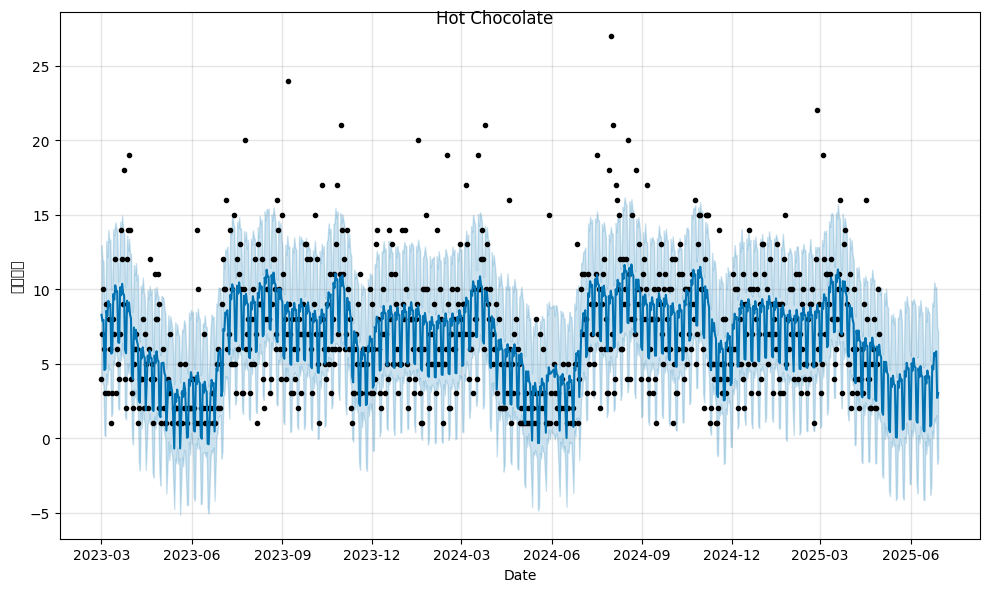

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx6i3ck7b/5dqz6_a2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx6i3ck7b/l56b5515.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15239', 'data', 'file=/tmp/tmpx6i3ck7b/5dqz6_a2.json', 'init=/tmp/tmpx6i3ck7b/l56b5515.json', 'output', 'file=/tmp/tmpx6i3ck7b/prophet_model6tvptz5f/prophet_model-20250921162648.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:26:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:26:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.12/dist-packages/prophet/plot.py:95: UserWarning: Glyph 3649 (\N{THAI CHARACTER SARA AE}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
/usr/local/lib/python3.12/dist-packages/prophet/plot.py:95: UserWarning: G

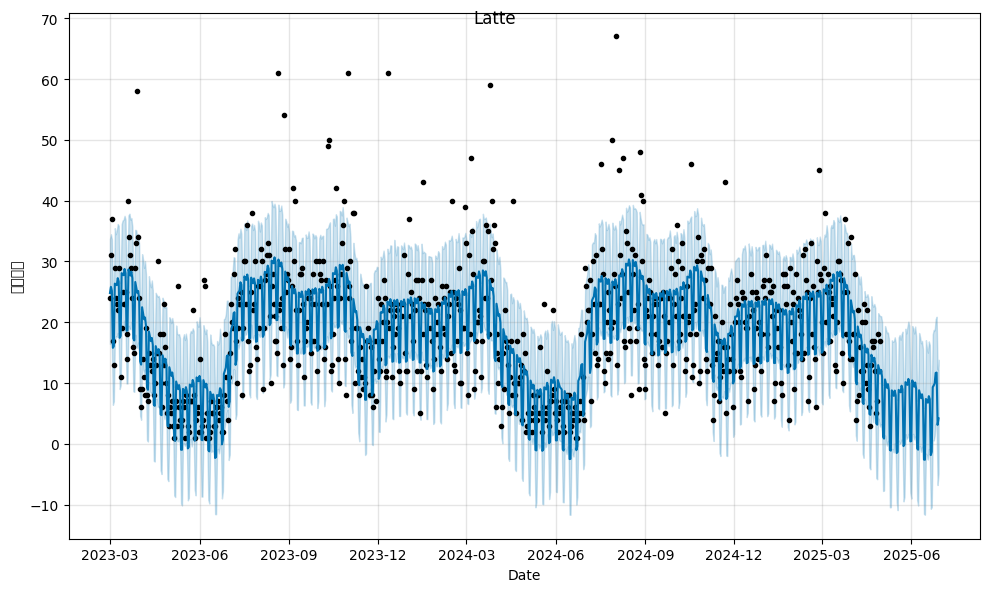

In [54]:
import pandas as pd
from prophet import Prophet
daily['date'] = pd.to_datetime(daily['date'])

for coffee in daily['coffee_name'].unique():
    df_cof = ( daily[daily['coffee_name']==coffee]
               .rename(columns={'date':'ds','count':'y'}) )

    m = Prophet(
        daily_seasonality=False,
        weekly_seasonality=True,
        yearly_seasonality=True
    )
    m.fit(df_cof)

    future = m.make_future_dataframe(periods=60)
    forecast = m.predict(future)

    fig = m.plot(forecast, xlabel='Date', ylabel='แก้ว')
    fig.suptitle(coffee)
    plt.show()